# EEG-ERP Preprocessing – Batch script
## Max Independent Research Project; Under Brynn and Danny
---

## Subject list

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
from os import remove
from glob import glob
from pathlib import Path
import yaml
from yaml import CLoader as Loader
import mne
mne.set_log_level('error')
from mne_bids import BIDSPath, read_raw_bids
from scipy.stats import zscore
from autoreject import Ransac, get_rejection_threshold, AutoReject
from time import time

## Read Parameters from config.yml

Will import study-level parameters from `config.yml` in `bids_root`

In [2]:
# this shouldn't change if you run this script from its default location in code/import
bids_root = '../..'

cfg_file = op.join(bids_root, 'config.yml')
with open(cfg_file, 'r') as f:
    config = yaml.load(f, Loader=Loader)

study_name = config['study_name']
task = config['task']
data_type = config['data_type']
eog = config['eog']
montage_fname = config['montage_fname']

# fix per changes to config
filt_p = {k: v for d in config['preprocessing_settings']['filter'] for k, v in d.items()}
n_jobs = filt_p['n_jobs']
ica_p =  {k: v for d in config['preprocessing_settings']['ica'] for k, v in d.items()}
epoch_p =  {k: v for d in config['preprocessing_settings']['epoch'] for k, v in d.items()}
baseline = tuple(epoch_p['baseline'])

## Event codes

In [3]:
trial_id = {'Neutral/Upright/Faces/Standard/L1':111, #Faces
            'Neutral/Upright/Faces/Standard/L2':112,
            'Neutral/Upright/Faces/Standard/L3':113,
            'Neutral/Upright/Faces/Standard/L4':114,
            'Neutral/Upright/Faces/Standard/L5':115,
            'Neutral/Upright/Faces/Standard/L6':116,

            'Neutral/Inverted/Faces/Standard/L1':121,
            'Neutral/Inverted/Faces/Standard/L2':122,
            'Neutral/Inverted/Faces/Standard/L3':123,
            'Neutral/Inverted/Faces/Standard/L4':124,
            'Neutral/Inverted/Faces/Standard/L5':125,
            'Neutral/Inverted/Faces/Standard/L6':126,

            'Green/Upright/Faces/Standard/L1':211,
            'Green/Upright/Faces/Standard/L2':212,
            'Green/Upright/Faces/Standard/L3':213,
            'Green/Upright/Faces/Standard/L4':214,
            'Green/Upright/Faces/Standard/L5':215,
            'Green/Upright/Faces/Standard/L6':216,

            'Green/Inverted/Faces/Standard/L1':221,
            'Green/Inverted/Faces/Standard/L2':222,
            'Green/Inverted/Faces/Standard/L3':223,
            'Green/Inverted/Faces/Standard/L4':224,
            'Green/Inverted/Faces/Standard/L5':225,
            'Green/Inverted/Faces/Standard/L6':226,
            
            'Neutral/Upright/Silhouettes/Standard/L1':131, #Silhouettes
            'Neutral/Upright/Silhouettes/Standard/L2':132,
            'Neutral/Upright/Silhouettes/Standard/L3':133,
            'Neutral/Upright/Silhouettes/Standard/L4':134,
            'Neutral/Upright/Silhouettes/Standard/L5':135,
            'Neutral/Upright/Silhouettes/Standard/L6':136,

            'Neutral/Inverted/Silhouettes/Standard/L1':141,
            'Neutral/Inverted/Silhouettes/Standard/L2':142,
            'Neutral/Inverted/Silhouettes/Standard/L3':143,
            'Neutral/Inverted/Silhouettes/Standard/L4':144,
            'Neutral/Inverted/Silhouettes/Standard/L5':145,
            'Neutral/Inverted/Silhouettes/Standard/L6':146,

            'Green/Upright/Silhouettes/Standard/L1':231,
            'Green/Upright/Silhouettes/Standard/L2':232,
            'Green/Upright/Silhouettes/Standard/L3':233,
            'Green/Upright/Silhouettes/Standard/L4':234,
            'Green/Upright/Silhouettes/Standard/L5':235,
            'Green/Upright/Silhouettes/Standard/L6':236,

            'Green/Inverted/Silhouettes/Standard/L1':241,
            'Green/Inverted/Silhouettes/Standard/L2':242,
            'Green/Inverted/Silhouettes/Standard/L3':243,
            'Green/Inverted/Silhouettes/Standard/L4':244,
            'Green/Inverted/Silhouettes/Standard/L5':245,
            'Green/Inverted/Silhouettes/Standard/L6':246
           }

target_highlight_id = {'Cue/L1':191,
                      'Cue/L2':192,
                      'Cue/L3':193,
                      'Cue/L4':194,
                      'Cue/L5':195,
                      'Cue/L6':196,
                     }

target_id = {'Neutral/Upright/Faces/Target/L1':1111, #Faces
            'Neutral/Upright/Faces/Target/L2':1112,
            'Neutral/Upright/Faces/Target/L3':1113,
            'Neutral/Upright/Faces/Target/L4':1114,
            'Neutral/Upright/Faces/Target/L5':1115,
            'Neutral/Upright/Faces/Target/L6':1116,

            'Neutral/Inverted/Faces/Target/L1':1121,
            'Neutral/Inverted/Faces/Target/L2':1122,
            'Neutral/Inverted/Faces/Target/L3':1123,
            'Neutral/Inverted/Faces/Target/L4':1124,
            'Neutral/Inverted/Faces/Target/L5':1125,
            'Neutral/Inverted/Faces/Target/L6':1126,

            'Green/Upright/Faces/Target/L1':1211,
            'Green/Upright/Faces/Target/L2':1212,
            'Green/Upright/Faces/Target/L3':1213,
            'Green/Upright/Faces/Target/L4':1214,
            'Green/Upright/Faces/Target/L5':1215,
            'Green/Upright/Faces/Target/L6':1216,

            'Green/Inverted/Faces/Target/L1':1221,
            'Green/Inverted/Faces/Target/L2':1222,
            'Green/Inverted/Faces/Target/L3':1223,
            'Green/Inverted/Faces/Target/L4':1224,
            'Green/Inverted/Faces/Target/L5':1225,
            'Green/Inverted/Faces/Target/L6':1226,
            
            'Neutral/Upright/Silhouettes/Target/L1':1131, #Silhouettes 
            'Neutral/Upright/Silhouettes/Target/L2':1132,
            'Neutral/Upright/Silhouettes/Target/L3':1133,
            'Neutral/Upright/Silhouettes/Target/L4':1134,
            'Neutral/Upright/Silhouettes/Target/L5':1135,
            'Neutral/Upright/Silhouettes/Target/L6':1136,

            'Neutral/Inverted/Silhouettes/Target/L1':1141,
            'Neutral/Inverted/Silhouettes/Target/L2':1142,
            'Neutral/Inverted/Silhouettes/Target/L3':1143,
            'Neutral/Inverted/Silhouettes/Target/L4':1144,
            'Neutral/Inverted/Silhouettes/Target/L5':1145,
            'Neutral/Inverted/Silhouettes/Target/L6':1146,

            'Green/Upright/Silhouettes/Target/L1':1231,
            'Green/Upright/Silhouettes/Target/L2':1232,
            'Green/Upright/Silhouettes/Target/L3':1233,
            'Green/Upright/Silhouettes/Target/L4':1234,
            'Green/Upright/Silhouettes/Target/L5':1235,
            'Green/Upright/Silhouettes/Target/L6':1236,

            'Green/Inverted/Silhouettes/Target/L1':1241,
            'Green/Inverted/Silhouettes/Target/L2':1242,
            'Green/Inverted/Silhouettes/Target/L3':1243,
            'Green/Inverted/Silhouettes/Target/L4':1244,
            'Green/Inverted/Silhouettes/Target/L5':1245,
            'Green/Inverted/Silhouettes/Target/L6':1246
           }

event_id = {**target_highlight_id, **trial_id, **target_id}

### Paths

In [4]:
raw_path = op.join(bids_root, 'rawdata')

derivatives_path = op.join(bids_root, 'derivatives', 'erp_preprocessing')
if Path(derivatives_path).exists() == False:
    Path(derivatives_path).mkdir(parents=True)

report_path = op.join(derivatives_path, 'logs')
if Path(report_path).exists() == False:
    Path(report_path).mkdir(parents=True)

epochs_suffix = '-epo.fif'

## Load list of ICs to manually add/remove

In [5]:
cfg_file = './participants_manual_ic.yml'
with open(cfg_file, 'r') as f:
    ica_manual = yaml.load(f, Loader=Loader)

### Subjects, Useful variables

In [6]:
# Full-Batch Preprocessing
prefix = 'sub-'
subjects = sorted([s[-7:] for s in glob(raw_path + '/' + prefix + '*')])
print("n subjects = ", len(subjects))
print(subjects)

# subjects = ['sub-002']

px = 1 / plt.rcParams['figure.dpi']  # pixel in inches

## Do Preprocessing


-------------------------
-------- sub-002 --------
-------------------------


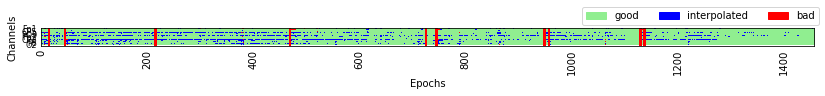

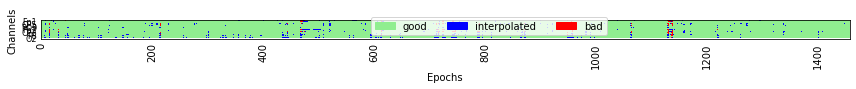

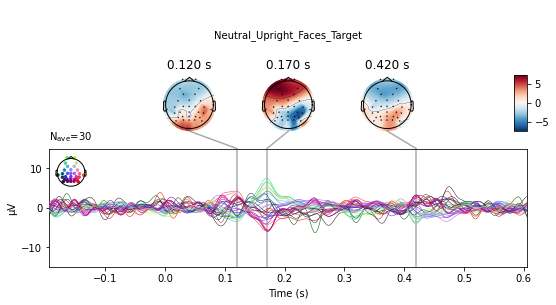

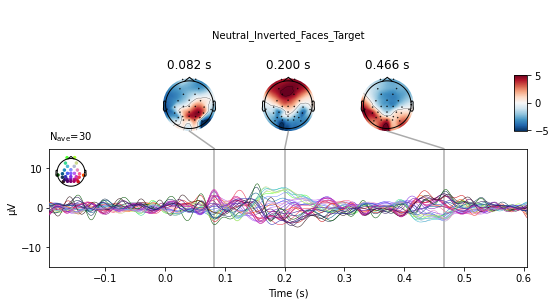

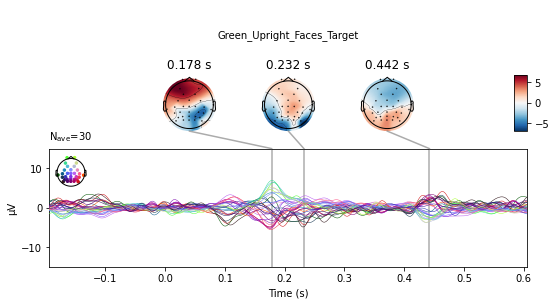

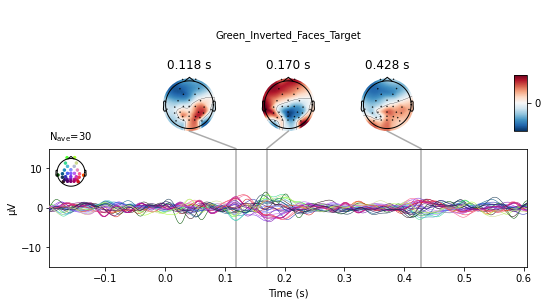

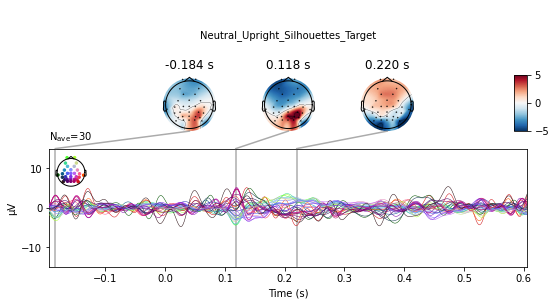

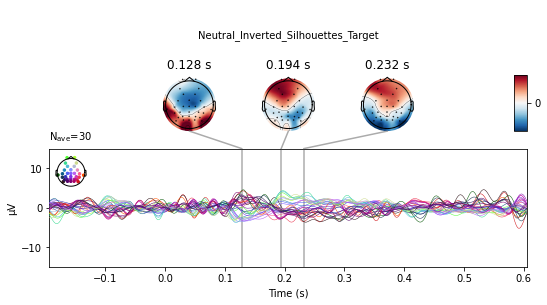

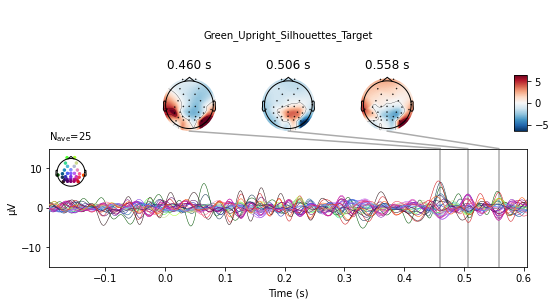

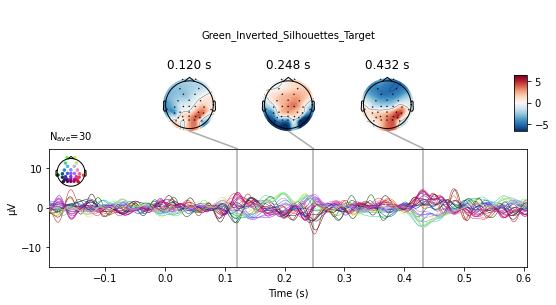

In [7]:
for subject in subjects:
    start_time = time()
    print('\n-------------------------')
    print('-------- ' + subject + ' --------')
    print('-------------------------')
    
    ### Read data
    report = mne.Report(subject=subject, 
                        title=study_name + ' preprocessing: ' + subject,
                        verbose='WARNING')

    ### subject-specific paths
    in_path = BIDSPath(root=raw_path, 
                        subject=subject[-3:], 
                        datatype=data_type,
                        task=task
                        )    

    ### Import data
    raw = read_raw_bids(in_path)

    ### Filtering

    # channel selection
    picks = mne.pick_types(raw.info, 
                           eeg=True,
                           eog=True
                          )

    ## Filter for ICA  
    raw_ica = raw.load_data().copy().filter(filt_p['l_freq_ica'], filt_p['h_freq'],
                                picks=picks,
                                n_jobs=n_jobs
                               )

    ## Filter for final
    raw.filter(filt_p['l_freq'], filt_p['h_freq'],
               picks=picks,
               n_jobs=n_jobs
              )

    ## Add raw to report
    report.add_raw(raw=raw, 
               psd=True, butterfly=True, 
               title='Raw data, bandpass filtered ' + str(filt_p['l_freq']) + '–' + str(filt_p['h_freq'])
              )

    ### Read events

    events, event_dict = mne.events_from_annotations(raw)

    ### Event Code Processing
    #### Find indices of codes of various types

    target_codes = sorted(target_highlight_id.values())
    target_highlights = np.squeeze(np.where((events[:, 2] >= target_codes[0])  
                                            & (events[:, 2] <= target_codes[-1])
                                           )
                                  )

    # add these first; events don't actually need to be listed in chronological order
    events_new = np.copy(events[target_highlights])

    for block, start_idx in enumerate(target_highlights):
        # find end of block from next target highlight, except for last block
        if block == len(target_highlights) - 1:
            block_trials = np.copy(events[start_idx + 1:])
        else:
            block_trials = np.copy(events[start_idx + 1:target_highlights[block + 1]])

        # isloate value in the the ones column, which specifies position of target
        target_code = events[start_idx, 2] % 10

        # create filter/mask
        targets = block_trials[:, 2] % 10 == target_code

        block_trials[targets, 2] = block_trials[targets, 2] + 1000

        events_new = np.vstack((events_new, block_trials))
        
    ### Create dictionary of event labels for only those event codes actually present in the data
    event_dict_new = {}
    codes_in_data = np.unique(events_new[:, 2])    

    for key, value in event_id.items():
        if value in codes_in_data:
            event_dict_new[key] = value

    ## Add events to report
    report.add_events(events_new, event_id=event_dict_new, 
                      sfreq=raw.info['sfreq'],
                      title='Events'
                     )
    

    #################################
    ### Epoch data filtered for ICA

    epochs_ica = mne.Epochs(raw_ica,
                            events_new, event_dict_new,
                            epoch_p['tmin'], epoch_p['tmax'],
                            baseline=None, detrend=epoch_p['detrend'],
                            reject=epoch_p['reject'], 
                            flat=epoch_p['flat'],
                            preload=True
                           )

    ### use AutoReject to remove bad epochs, repair sensors and return clean epochs.

    ar = AutoReject(n_interpolate=[1, 2, 4, 8],
                    consensus=np.array([.5, 1., 11.]),
                    random_state=ica_p['ica_random_state'],
                    picks=mne.pick_types(epochs_ica.info, eeg=True, eog=False),
                    n_jobs=n_jobs, 
                    verbose=False
                   )

    ar.fit(epochs_ica)

    reject_log = ar.get_reject_log(epochs_ica)
    fig = reject_log.plot('horizontal')
    report.add_figure(fig=fig, title='AutoReject log, pre-ICA')

    ### Fit ICA

    ica = mne.preprocessing.ICA(method='fastica',
                                n_components=ica_p['n_components'],
                                random_state=ica_p['ica_random_state'],
                                max_iter='auto')

    ica.fit(epochs_ica[~reject_log.bad_epochs],  # added [~reject_log.bad_epochs] for AutoReject
            decim=3, 
            # reject=reject,  # removed this line as I think it's redundant
            picks=['eeg']
            );

    ### Identify ocular ICs

    # The default *z* threshold doesn't work for
    # all subjects. This routine starts with the default z (from config) and steps down
    # until at least n_min_eog EOG components are identified.
    # The limitations of this are that it assumes there will always be at least n_min_eog EOG
    # components (blinks are always present, but horizontal movements are not
    # always present), and may not work if there are > 3 components, if the
    # score of the third is > `z_step` less than the score of the second.
    # In practice, many of these components (with EGI data) may not be ocular, but are (hopefully) not EEG.
    # Be sure to check the reports and confirm no ERP components are rejected!

    ica.exclude = []
    num_excl = 0
    z_thresh = ica_p['ica_zthresh'] 
    z_step = ica_p['ica_zstep']

    while num_excl < ica_p['n_min_eog']:
        eog_indices, eog_scores = ica.find_bads_eog(epochs_ica, threshold=z_thresh)
        num_excl = len(eog_indices)
        z_thresh -= z_step # won't impact things if num_excl is ≥ n_min_eog 

    ica.exclude = eog_indices
    z_thresh_final = round(z_thresh + z_step, 2)

    # Manual removal/re-addition of ICs based on visual inspection
    if subject in ica_manual:
        if 'add_ics' in ica_manual[subject]:
            for ic in ica_manual[subject]['add_ics']:
                ica.exclude.append(ic)
        if 'rm_ics' in ica_manual[subject]:
            for ic in ica_manual[subject]['rm_ics']:
                ica.exclude.remove(ic)         

    # Create average of EOG events
    eog_evoked = mne.preprocessing.create_eog_epochs(raw_ica).average().apply_baseline(baseline=(None, epoch_p['tmin']))

    ## Add ICA to report
    report.add_ica(ica=ica, title='ICA', inst=epochs_ica,
                   eog_evoked=eog_evoked, 
                   eog_scores=eog_scores,
                   n_jobs=n_jobs
                  )

    ### Epoch filtered raw data into epochs for final analysis

    epochs = mne.Epochs(raw,
                        events_new, event_dict_new,
                        epoch_p['tmin'], epoch_p['tmax'],
                        baseline=None, detrend=epoch_p['detrend'],
                        reject=epoch_p['reject'], 
                        flat=epoch_p['flat'],
                        preload=True
                       )

    ### Apply ICA correction to epochs

    ica.apply(epochs)

    ### Apply AutoReject to further clean epochs

    ar = AutoReject(n_interpolate=[1, 2, 4, 8],
                    consensus=np.array([.5, 1., 11.]),
                    random_state=ica_p['ica_random_state'],
                    picks=mne.pick_types(epochs_ica.info, eeg=True, eog=False),
                    n_jobs=n_jobs, 
                    verbose=False
                   )
    epochs_clean, reject_log = ar.fit_transform(epochs, return_log=True)
    ### Plot autoreject log
    fig = reject_log.plot('horizontal')
    report.add_figure(fig=fig, title='AutoReject log, post-ICA')


    ### Re-reference, now that channels are cleaned
    #### Also, apply time shift to compensate for delay between code and onset of visual stim (based on empirical timing test)

    epochs_clean.set_eeg_reference(ref_channels=epoch_p['rereference']).shift_time(epoch_p['tshift'], relative=True);

    # add epochs to report
    report.add_epochs(epochs_clean,  
                      title='Epochs'
                     )

    ### Save cleaned epochs

    out_path = BIDSPath(root=derivatives_path, 
                       subject=subject[-3:], 
                       datatype=data_type,
                       task=task
                      )    
    # remove old fif file if it exists, and update bids_path
    if str(out_path.fpath)[-len(epochs_suffix):] == epochs_suffix:
        remove(out_path.fpath)
        out_path = BIDSPath(root=derivatives_path, 
                   subject=subject[-3:], 
                   datatype=data_type,
                   task=task
                  )    
    # save the file
    epochs_clean.save(str(out_path.fpath) + epochs_suffix, 
                      overwrite=True)

    ### Save plot of average across all trials

    fig = epochs_clean.copy().average().apply_baseline(baseline).plot(spatial_colors=True, show=False);

    # add figure to report
    
    report.add_figure(fig=fig, title='Grand average over all epochs')
    plt.close(fig)

    ### Add plots of average of each condition

    coi = ['Neutral/Upright/Faces/Target',
           'Neutral/Inverted/Faces/Target',
           'Green/Upright/Faces/Target',
           'Green/Inverted/Faces/Target',
           'Neutral/Upright/Silhouettes/Target',
           'Neutral/Inverted/Silhouettes/Target',
           'Green/Upright/Silhouettes/Target',
           'Green/Inverted/Silhouettes/Target',
          ]

    ylim = 15
    for condition in coi:
        fig = epochs_clean[condition].copy().average().plot_joint(title=('_').join(condition.split('/')),
                                                                    ts_args={'ylim':{'eeg':[-ylim,  ylim]}},
                                                                    show=True)
        report.add_figure(fig=fig, title=condition)
        plt.close(fig)

    ### Save report to file
    report_name = report_path + '/' + subject + '.html'
    report.save(report_name, overwrite=True)
    